In [6]:
%load_ext autoreload
%autoreload 2

import xarray as xr
import pandas as pd
import numpy as np
import xgcm
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 16

from osse import *
from canyon_utils import *
from sloped_MITgcm import *

import warnings
warnings.filterwarnings('ignore', '.*.')

div_cmap = plt.get_cmap('RdBu_r')
div_cmap.set_bad(color=(0.8,0.8,0.8))

cmap = plt.get_cmap('viridis')
cmap.set_bad(color=(0.8,0.8,0.8))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
1+1

### Physical parameters

In [7]:
Γ = 0.0008613659531090722
N = np.sqrt(g*α*Γ)
θ = 1.26E-3
f = 5.3e-5

h = 230
k0 = 5.2e-5
k1 = 1.8e-3

dx = 600.
delta_t = 30.

### Load dataset

In [8]:
data_dir = "../../MITgcm/experiments/rotated_BBTRE_canyon-tracer/run/"
ds = open_mdsdataset(data_dir,ignore_unknown_vars=True,prefix=["standardDiag"], delta_t=delta_t)
print(f"Δt = {(ds['time'][-1] - ds['time'][0]).values*1e-9/(24*60*60)} days")
ds = ds.mean('time')
ds, grid = add_rotated_coords(ds, θ)
ds = add_thalweg(ds)
ds = add_background_temp(ds, Γ)

Δt = 0 days


### Load bathymetry and hydrography

In [9]:
geo_XY = xr.open_dataset("../../MITgcm/experiments/rotated_BBTRE_canyon/input/geocoords.nc").drop(["X", "Y"])
bathy = xr.open_dataset("../../data/Tozer2019_bathymetry.nc")

cdf = pd.read_csv("../../data/BBTRE_hydrography_hab-binned.csv")

In [10]:
cdf.head()

,Unnamed: 0,cast number,in canyon,bottom pressure,latitude,longitude,pressure above bottom,salinity,temperature,sigma4,pressure_f above bottom,Nsq
0,0,10,True,5233.94,-21.784167,-19.4215,-3000.0,34.935204,3.148965,45.597848,NaN,0.000001
1,1,10,True,5233.94,-21.784167,-19.4215,-2950.0,34.933760,3.115585,45.604072,-2950.0,0.000001
2,2,10,True,5233.94,-21.784167,-19.4215,-2900.0,34.932982,3.089895,45.609357,-2900.0,0.000001
3,3,10,True,5233.94,-21.784167,-19.4215,-2850.0,34.931132,3.056363,45.615290,-2850.0,0.000001
4,4,10,True,5233.94,-21.784167,-19.4215,-2800.0,34.929147,3.019005,45.621836,-2800.0,0.000001


## Load Thurnherr's microstructure profile categorization

In [11]:
df = pd.read_csv("../../data/BBTRE_Stations_with_classification/1997_BBTRE_2/STATIONS.annot", dtype=str, header=19)
lines = []
for i in range(df.size):
    line = [np.float(e.strip(' ')) for e in str(df.iloc[i].values[0]).replace("\t", " ").split(" ") if len(e.strip(" "))>0]
    lines.append(line)
ndf = pd.DataFrame(lines, columns=["castnum", "latitude", "longitude", "bottom pres", "bottom dep", "max depth", "canyon", "SeaBeam"])
ndf.head()

,castnum,latitude,longitude,bottom pres,bottom dep,max depth,canyon,SeaBeam
0,1.0,-13.3092,-30.3815,NaN,NaN,971.554,NaN,NaN
1,2.0,-16.3205,-27.6578,5469.00,5368.239079,5049.950,NaN,NaN
2,3.0,-21.9225,-22.3100,5425.00,5323.870070,5298.660,NaN,NaN
3,4.0,-21.9170,-21.3892,5394.47,5294.268873,5208.950,NaN,NaN
4,5.0,-21.8795,-20.8445,5441.87,5340.240861,5269.580,NaN,NaN


# Map of hydrographic and microstructure profiles

Colored by whether Thurnherr classified as "in-canyon".

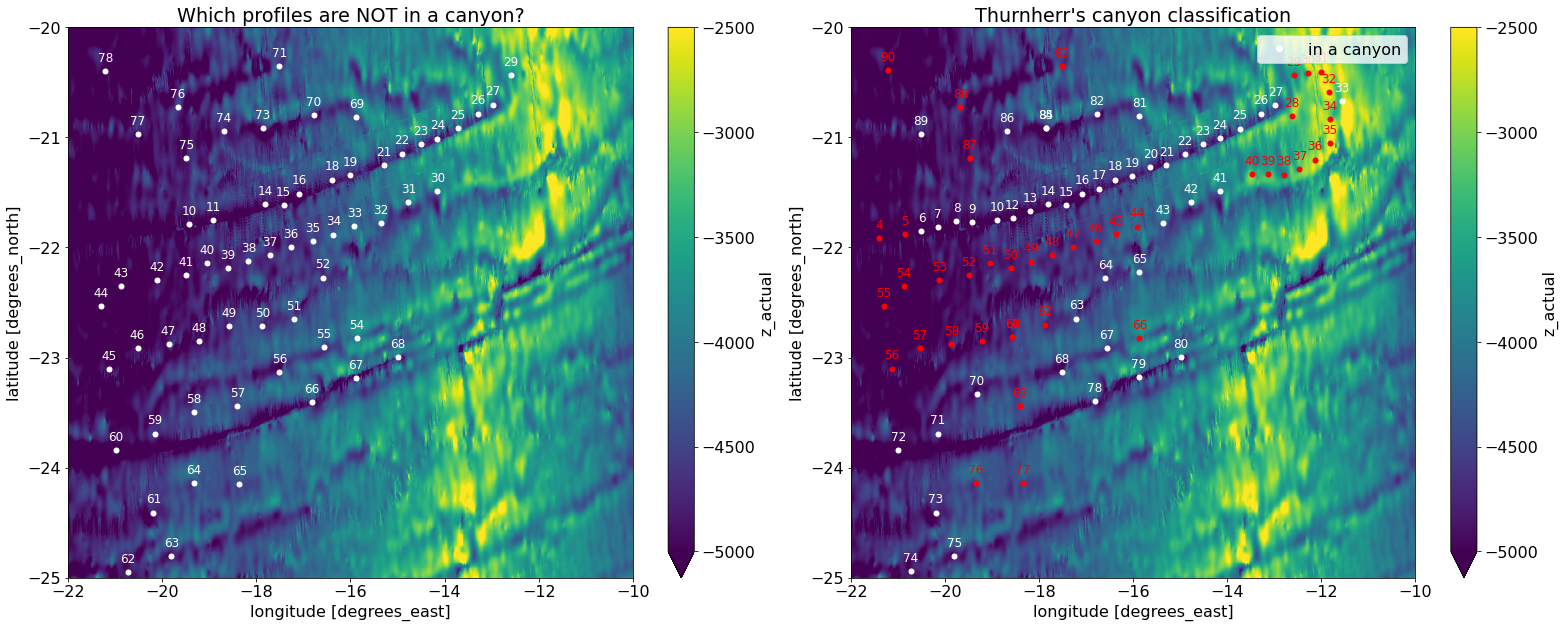

In [12]:
plt.figure(figsize=(22,9))
ax = plt.subplot(1,2,1)
q = bathy['z'].sel(lon=slice(-22, -10), lat=slice(-25, -20)).plot(ax=ax,x='lon', y='lat', vmin=-5000, vmax=-2500)
q.colorbar.remove()
geo_XY['z_actual'].plot(ax=ax, x='lon', y='lat', vmin=-5000, vmax=-2500)
for num in np.unique(cdf['cast number']):
    cast = cdf[cdf['cast number']==num].iloc[0]
    if cdf[cdf['cast number']==num].iloc[0]['latitude'].dtype == 'float64':
        x = cast['longitude']
        y = cast['latitude']
        ax.plot(x, y, color="w", marker="o", markersize=5)
        ax.annotate(num, # this is the text
             (x,y), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(0,10), # distance from text to points (x,y)
             fontsize=12,
             color='w',
             ha='center'
        )
plt.title("Which profiles are NOT in a canyon?")
plt.tight_layout()

ax = plt.subplot(1,2,2)
q = bathy['z'].sel(lon=slice(-22, -10), lat=slice(-25, -20)).plot(ax=ax,x='lon', y='lat', vmin=-5000, vmax=-2500)
q.colorbar.remove()
geo_XY['z_actual'].plot(ax=ax, x='lon', y='lat', vmin=-5000, vmax=-2500)
for num in np.unique(ndf['castnum']):
    cast = ndf[ndf['castnum']==num].iloc[0]
    if cast['latitude'].dtype == 'float64':
        x = cast['longitude']
        y = cast['latitude']
        if (x<-22) | (x>-10) | (y>-20) | (y<-25): continue
        col='w'
        if np.isnan(cast['canyon']): col='r'
        ax.plot(x, y, color=col, marker="o", markersize=5)
        ax.annotate(np.int(num), # this is the text
             (x,y), # this is the point to label
             textcoords="offset points", # how to position the text
             xytext=(0,10), # distance from text to points (x,y)
             fontsize=12,
             color=col,
             ha='center'
        )
plt.plot([],[], "wo", label="in a canyon")
plt.title("Thurnherr's canyon classification")
plt.legend()
plt.tight_layout()

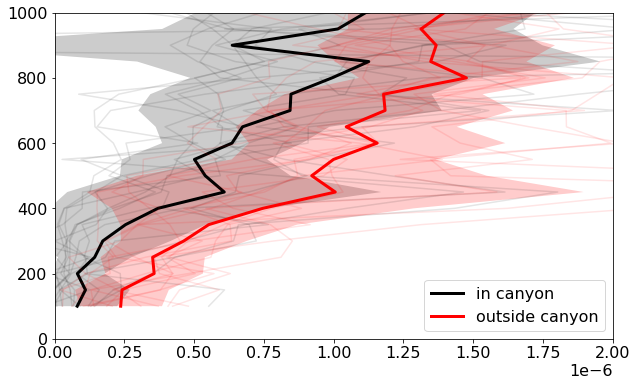

In [189]:
in_list = np.arange(10,28)
out_list = np.arange(33,45)

nz = 60
in_arr = np.ones((nz, len(in_list)))*np.nan
for i, num in enumerate(in_list):
    if num in cdf['cast number']:
        tmp_df = cdf[cdf['cast number']==num]
        if len(tmp_df)>0:
            plt.plot(tmp_df['Nsq'], -tmp_df['pressure_f above bottom'], "k-", alpha=0.1)
            plt.ylim([0, 1000])
            in_arr[:, i] = tmp_df['Nsq']
plt.fill_betweenx(-tmp_df['pressure_f above bottom'], np.nanmean(in_arr,axis=1) - np.nanstd(in_arr,axis=1), np.nanmean(in_arr,axis=1) + np.nanstd(in_arr,axis=1), facecolor="k", alpha=0.2)
plt.plot(np.nanmean(in_arr,axis=1), -tmp_df['pressure_f above bottom'], "k-", lw=3, label="in canyon")

out_arr = np.ones((nz, len(out_list)))*np.nan
for i, num in enumerate(out_list):
    if num in cdf['cast number']:
        tmp_df = cdf[cdf['cast number']==num]
        if len(tmp_df)>0:
            plt.plot(tmp_df['Nsq'], -tmp_df['pressure_f above bottom'], "r-", alpha=0.1)
            plt.ylim([0, 1000])
            out_arr[:, i] = tmp_df['Nsq']
            
plt.fill_betweenx(-tmp_df['pressure_f above bottom'], np.nanmean(out_arr,axis=1) - np.nanstd(out_arr,axis=1), np.nanmean(out_arr,axis=1) + np.nanstd(out_arr,axis=1), facecolor="r", alpha=0.2)
plt.plot(np.nanmean(out_arr,axis=1), -tmp_df['pressure_f above bottom'], "r-", lw=3, label="outside canyon")
plt.xlim([0, 2e-6])
plt.legend()

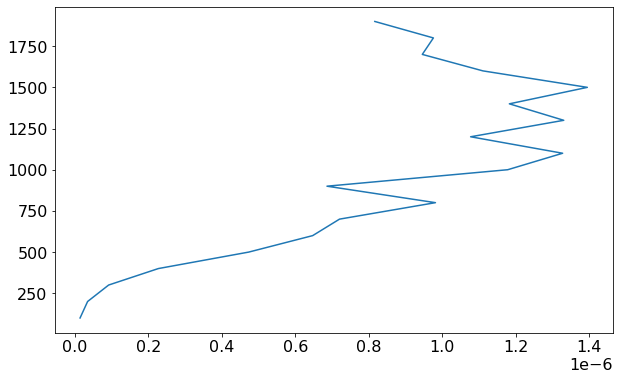

(0.0, 1500.0)

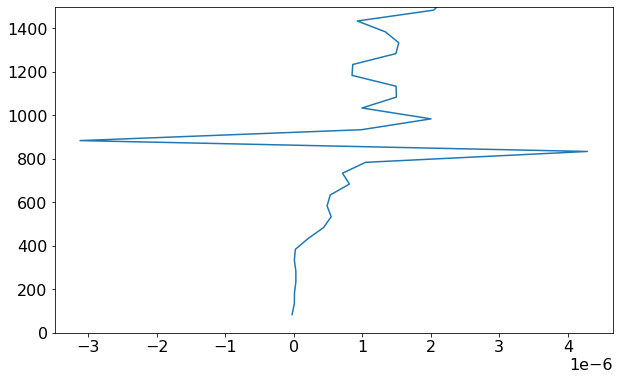

In [90]:
casts = cdf['cast number'].unique()

lons, lats = [], []
for cast in casts:
    lons.append(cdf[cdf['cast number']==cast]['longitude'].values[0])
    lats.append(cdf[cdf['cast number']==cast]['latitude'].values[0])

In [91]:
def global_argmin(da):
    xmin = da.min(dim=['Xr'])
    xargmin = da.argmin(dim='Xr').values
    yargmin = xmin.argmin(dim='Yr').values
    return [xargmin[yargmin], yargmin], xmin[yargmin].values

In [92]:
sample_locs = []
sample_casts = []
sample_coords = []
for c, cast in enumerate(casts):
    if np.isnan(lats[c]) | np.isnan(lons[c]): continue
    mindist = ((geo_XY['lat']-lats[c])**2 + (geo_XY['lon']-lons[c])**2)
    argmin, _ = global_argmin(mindist)
    if (
        (argmin[0] == 0) | (argmin[0] == geo_XY.dims['Xr']-1) |
        (argmin[1] == 0) | (argmin[1] == geo_XY.dims['Yr']-1)
    ):
        print(f"Cast {cast} is outside domain")
        continue
    sample_locs.append(argmin)
    sample_coords.append([lons[c], lats[c]])
    sample_casts.append(cast)

Cast 10 is outside domain
Cast 11 is outside domain
Cast 25 is outside domain
Cast 26 is outside domain
Cast 27 is outside domain
Cast 29 is outside domain
Cast 30 is outside domain
Cast 31 is outside domain
Cast 32 is outside domain
Cast 33 is outside domain
Cast 34 is outside domain
Cast 35 is outside domain
Cast 36 is outside domain
Cast 37 is outside domain
Cast 38 is outside domain
Cast 39 is outside domain
Cast 40 is outside domain
Cast 41 is outside domain
Cast 42 is outside domain
Cast 43 is outside domain
Cast 44 is outside domain
Cast 45 is outside domain
Cast 46 is outside domain
Cast 47 is outside domain
Cast 48 is outside domain
Cast 49 is outside domain
Cast 50 is outside domain
Cast 51 is outside domain
Cast 52 is outside domain
Cast 54 is outside domain
Cast 55 is outside domain
Cast 56 is outside domain
Cast 57 is outside domain
Cast 58 is outside domain
Cast 59 is outside domain
Cast 60 is outside domain
Cast 61 is outside domain
Cast 62 is outside domain
Cast 63 is o

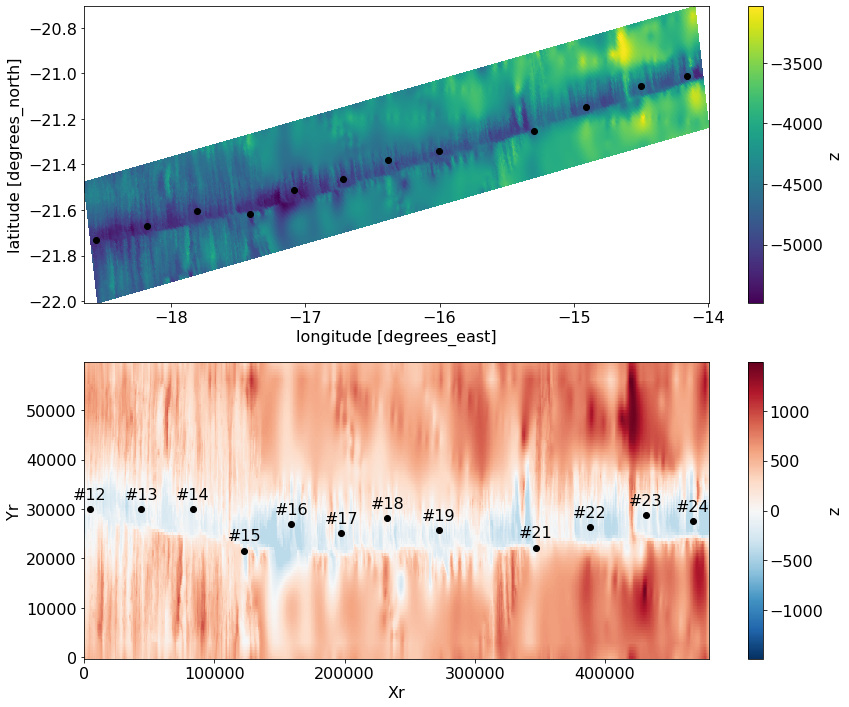

In [93]:
plt.figure(figsize=(14,12))

plt.subplot(2,1,1)
geo_XY['z_with_slope'].plot(x='lon', y='lat')
for loc in sample_locs:
    plt.plot(geo_XY['lon'].isel(Xr=loc[0], Yr=loc[1]).values, geo_XY['lat'].isel(Xr=loc[0], Yr=loc[1]).values, "ko")
    
plt.subplot(2,1,2)
geo_XY['z'].plot()
for c, loc in enumerate(sample_locs):
    x = geo_XY['Xr'].isel(Xr=loc[0]).values
    y = geo_XY['Yr'].isel(Yr=loc[1]).values
    plt.plot(x, y, "ko")
    label = f"#{sample_casts[c]}"
    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center')
    
plt.savefig("../../figures/BBTRE/canyon_casts_map.png", dpi=150, bbox_inches="tight")

NameError: name 'ds' is not defined

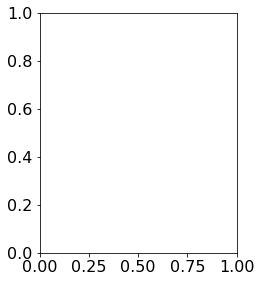

In [94]:
plt.figure(figsize=(12, 15))

for c, loc in enumerate(sample_locs):
    plt.subplot(3,3,c+1)
    tmp = ds['Nsq'].isel(XC=loc[0], YC=loc[1], time=-1)
    plt.semilogx(tmp, -(ds['Zl']+geo_XY['z_with_slope'].min().values.copy().astype('>f8')))
    
    tmp_df = cdf[cdf['cast number']==casts[c]]
    plt.semilogx(tmp_df['Nsq'], tmp_df['pressure'], '--')
    plt.ylim([5500, 3500])
    plt.title(f"Cast {sample_casts[c]} ({round(sample_coords[c][0],1)}, {round(sample_coords[c][1],1)})")
    plt.xlim([1.e-9,3.e-6])
    plt.xlabel(r"stratification [s$^{-2}$]")
    plt.ylabel("depth [m]")
    
plt.tight_layout()
plt.savefig("../../figures/BBTRE/canyon_casts_comparison.png", dpi=150, bbox_inches="tight")

In [ ]:
ds['ϵ'] = ds['KVDIFF']*ds['Nsq']/0.2

In [ ]:
q = ds['ϵ'].isel(time=-1, YC=60).plot(cmap='viridis')
q.set_clim([0, 2.e-8])
plt.ylim([300,2000])

In [ ]:
ϵ_hab = hab_interp(ds['ϵ'], vert_coord = 'Zl').compute()

In [ ]:
plt.figure(figsize=(16,6))

plt.subplot(1,2,1)
q = ϵ_hab.isel(YC=20, time=0).plot(y='hab', cmap='viridis')
q.set_clim([0., 1.e-8])
plt.title("Dissipation on the flanks")
plt.ylim([0,1500])

plt.subplot(1,4,3)
plt.semilogx(mean_profile(ϵ_hab.isel(YC=[20], time=0)), ϵ_hab['hab'])
plt.xlim([4.e-10, 1.e-8])
plt.xticks([1.e-9])
plt.grid(True)
plt.ylabel("hab [m]")
plt.xlabel("$\epsilon$ [W kg$^{-1}$]")
plt.ylim([0,1500])

plt.tight_layout()

In [ ]:
plt.figure(figsize=(19,7))

plt.subplot(1,2,1)
q = ϵ_hab.isel(YC=60, time=0).plot(y='hab', cmap='viridis')
q.set_clim([0., 1.e-8])
plt.title("Dissipation in the canyon")
plt.ylim([0,1500])

plt.subplot(1,4,3)
plt.semilogx(mean_profile(ϵ_hab.isel(YC=[60], time=0)), ϵ_hab['hab'], label = "canyon")
plt.semilogx(mean_profile(ϵ_hab.isel(YC=[65], time=0)), ϵ_hab['hab'], "C1-", label = "canyon north slope")
plt.semilogx(mean_profile(ϵ_hab.isel(YC=[55], time=0)), ϵ_hab['hab'], "C1--", label = "canyon south slope")
plt.semilogx(mean_profile(ϵ_hab.isel(YC=[90], time=0)), ϵ_hab['hab'], "C2-", label = "north flank")
plt.semilogx(mean_profile(ϵ_hab.isel(YC=[30], time=0)), ϵ_hab['hab'], "C2--", label = "south flank")
plt.xlim([4.e-10, 2.e-8])
plt.xticks([1.e-9])
plt.grid(True)
plt.ylabel("hab [m]")
plt.xlabel("$\epsilon$ [W kg$^{-1}$]")
plt.ylim([0,1500])
plt.legend(loc='upper right')

plt.tight_layout()

In [ ]:
plt.figure(figsize=(12, 15))

for c, loc in enumerate(sample_locs):
    plt.subplot(3,3,c+1)
    tmp = ds['ϵ'].isel(XC=loc[0], YC=loc[1], time=-1)
    plt.semilogx(tmp, -(ds['Zl']+geo_XY['z_with_slope'].min().values.copy().astype('>f8')))
    plt.ylim([5100, 4000])
    
plt.tight_layout()
plt.savefig("../../figures/BBTRE/canyon_casts_comparison_epsilon.png", dpi=150, bbox_inches="tight")

### Plotting

In [ ]:
coords['Depth'].plot()

In [ ]:
ds['KVDIFF'].isel(XC=250, time=0).plot()

In [ ]:
plt.figure(figsize=(12,18))

plt.subplot(3,1,1, facecolor=(.8, .8, .8))
ds['UVEL'] = ds['UVEL'].where(ds['UVEL'] != 0.)
ds['UVEL'].isel(time=-1).sel(Z=900, method='nearest').plot(cmap=div_cmap)

plt.subplot(3,1,2, facecolor=(.8, .8, .8))
q = ds['UVEL'].isel(time=-1).sel(YC=3e4, method='nearest').plot(x='Xr_U', y='Zr_U')
q.set_clim([-2e-2, 2e-2])
ds['THETA_BG'].isel(time=-1).sel(YC=3e4, method='nearest').plot.contour(x='Xr', y='Zr', colors='black', levels=np.arange(0.4, 2.5, 0.25))
plt.ylim([200,2500])

plt.subplot(3,1,3, facecolor=(.8, .8, .8))
q = ds['UVEL'].isel(time=-1).sel(XG=1.5e5, method='nearest').plot(x='YC', y='Zr_U')
q.set_clim([-2e-2, 2e-2])
ds['THETA_BG'].isel(time=-1).sel(XC=1.5e5, method='nearest').plot.contour(x='YC', y='Zr', colors='black', levels=np.arange(0.4, 2.5, 0.25))
plt.ylim([200,2500])
plt.xlim([6.e4, 0.])

plt.tight_layout()
plt.savefig("../../figures/BBTRE_u.png", bbox_inches='tight', dpi=100.)

In [ ]:
plt.figure(figsize=(12,18))

plt.subplot(3,1,1, facecolor=(.8, .8, .8))
ds['WVEL'] = ds['WVEL'].where(ds['WVEL'] != 0.)
ds['WVEL'].isel(time=-1).sel(Zl=900, method='nearest').plot(cmap=div_cmap)

plt.subplot(3,1,2, facecolor=(.8, .8, .8))
q = ds['WVEL'].isel(time=-1).sel(YC=3e4, method='nearest').plot(x='Xr_W', y='Zr_W')
ds['THETA_BG'].isel(time=-1).sel(YC=3e4, method='nearest').plot.contour(x='Xr', y='Zr', colors='black', levels=np.arange(0.4, 2.5, 0.05))
plt.ylim([200,2500])

plt.subplot(3,1,3, facecolor=(.8, .8, .8))
q = ds['WVEL'].isel(time=-1).sel(XC=1.5e5, method='nearest').plot(x='YC', y='Zr_W')
ds['THETA_BG'].isel(time=-1).sel(XC=1.5e5, method='nearest').plot.contour(x='YC', y='Zr', colors='black', levels=np.arange(0.4, 2.5, 0.05))
plt.ylim([200,2500])
plt.xlim([6.e4, 0.])

plt.tight_layout()
plt.savefig("../../figures/BBTRE_w.png", bbox_inches='tight', dpi=100.)

In [ ]:
plt.figure(figsize=(14,8))

ζ = ζ.where(ζ != 0.)
p = (ζ/f).isel(time=-1).sel(Z=1200, method='nearest').plot(cmap=div_cmap)
p.set_clim([-1.,1.])

In [ ]:
plt.figure(figsize=(14,8))

ζ = ζ.where(ζ != 0.)
p = (ζ/f).isel(time=-1).sel(Z=2500, method='nearest').plot(cmap=div_cmap)
p.set_clim([-0.1,0.1])

